# Convolution Arithmetics with TensorFlow
A practical introduction to convolution with TF.

Size and padding policies of TF are described in:
https://www.tensorflow.org/api_docs/python/nn.html#convolution

Animated GIFs comes from: https://github.com/vdumoulin/conv_arithmetic
and I suggest reading their article: https://arxiv.org/abs/1603.07285

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt # Used to plot stuff
plt.set_cmap('viridis') # Specify the color mapping (value -> color)

def show_pixel_image(*images, width=2, height=2, show_text=False, int_values=True):
    '''Plot the data wihout interpolation, optionally displaying
    the values over the cells'''
    from itertools import product
    # Scale image size
    plt.figure(figsize=(width * len(images), height))
    # Plot each figure in a row
    for i, data in enumerate(images, 1):
        plt.subplot(1, len(images), i)
        plt.axis('off') # Hide axis
        plt.imshow(data, interpolation='nearest')
        if show_text:
            if int_values:
                for y, x in product(range(data.shape[0]), range(data.shape[1])):
                    plt.text(x, y, int(data[y,x]), va='center', ha='center')
            else:
                for y, x in product(range(data.shape[0]), range(data.shape[1])):
                    plt.text(x, y, data[y,x], va='center', ha='center')

def conv2d(image, kernel, strides, padding):
    '''Prepare tf.nn.conv2d op for the given input.
    Strides shall be a (height, width) tuple/list.'''
    c_batch = tf.constant(image, dtype=tf.float32)
    img = tf.reshape(c_batch, (1, image.shape[0], image.shape[1], 1))
    c_kern = tf.constant(kernel, dtype=tf.float32)
    ker = tf.reshape(c_kern, (kernel.shape[0], kernel.shape[1], 1, 1))
    return tf.nn.conv2d(img, ker, strides=(1,)+strides+(1,), padding=padding)

def conv2d_t(image, kernel, out_shape, strides, padding):
    '''Prepare tf.nn.conv2d_transpose op for the given input.'''
    c_batch = tf.constant(image, dtype=tf.float32)
    img = tf.reshape(c_batch, (1, image.shape[0], image.shape[1], 1))
    c_kern = tf.constant(kernel, dtype=tf.float32)
    ker = tf.reshape(c_kern, (kernel.shape[0], kernel.shape[1], 1, 1))
    shape = tf.pack((1,)+out_shape+(1,))
    return tf.nn.conv2d_transpose(img, ker, shape, strides=(1,)+strides+(1,), padding=padding)

def show_conv2d(image, kernel, strides, padding, **kwargs):
    '''Run conv2d and shows the images'''
    with tf.Session() as sess:
        out = conv2d(image, kernel, strides, padding).eval()
        out = out.reshape(out.shape[1], out.shape[2])
        show_pixel_image(image, kernel, out, show_text=True, **kwargs)

def show_conv2d_any_pad(image, kernel, strides, padding=[(0, 0), (0, 0)], **kwargs):
    '''Like show_conv2d, but uses tf.pad to add custom padding to height or width of the input image.
    The VALID method is used.'''
    with tf.Session() as sess:
        c_batch = tf.constant(image, dtype=tf.float32)
        img = tf.reshape(c_batch, (1, image.shape[0], image.shape[1], 1))
        p_img = tf.pad(img, [(0, 0)] + padding + [(0, 0)])
        c_kern = tf.constant(kernel, dtype=tf.float32)
        ker = tf.reshape(c_kern, (kernel.shape[0], kernel.shape[1], 1, 1))
        op = tf.nn.conv2d(p_img, ker, strides=(1,) + strides + (1,), padding='VALID')
        _, i_h, i_w, _ = p_img.get_shape()
        _, o_h, o_w, _ = op.get_shape()
        show_pixel_image(p_img.eval().reshape(i_h, i_w), kernel, op.eval().reshape(o_h, o_w), **kwargs)

def compute_out_and_padding(in_size, filter_size, stride, method):
    '''This function returns output size and padding along a single dimension
    according to the tensorflow policies.'''
    from math import ceil
    
    if method == 'VALID':
        out_size = ceil((in_size - filter_size + 1) / stride)
        return out_size, 0
    elif method == 'SAME':
        out_size = ceil(in_size / stride)
        padding = ((out_size - 1) * stride + filter_size - in_size) / 2
        return out_size, padding
    else:
        return None


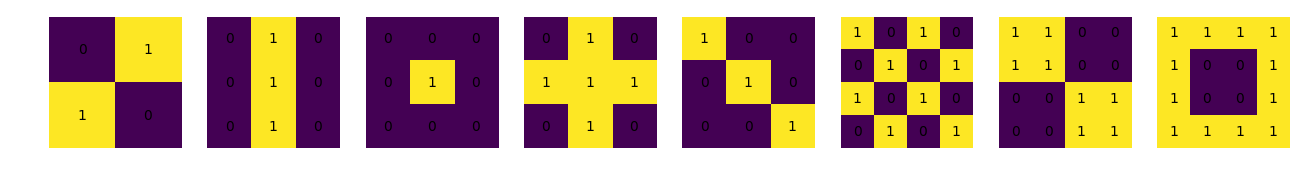

In [2]:
# Few images that we will use to explore the operations
image2_diag = np.array([[0, 1], [1, 0]])

image3_vert = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]])
image3_cent = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
image3_cros = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
image3_diag = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

image4_dots = np.array([[1,0,1,0], [0,1,0,1], [1,0,1,0], [0,1,0,1]])
image4_squa = np.array([[1,1,0,0], [1,1,0,0], [0,0,1,1], [0,0,1,1]])
image4_ring = np.array([[1,1,1,1], [1,0,0,1], [1,0,0,1], [1,1,1,1]])

show_pixel_image(image2_diag, image3_vert, image3_cent, image3_cros, image3_diag, image4_dots, image4_squa, image4_ring, show_text=True)

No padding, no strides ![no padding, no strides](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

Using the VALID padding, strides will be always zero, and the output size will be 2, because, according to [tensorflow convolution arithmetic](https://www.tensorflow.org/api_docs/python/nn.html#convolution), we have

    out_size = ceil((in_size - filter_size + 1) / stride)

In [3]:
compute_out_and_padding(4, 3, 1, 'VALID')

(2, 0)

First we use a 3x3 kernel with 1 just in the center and 0 elsewhere. Using VALID padding, conv2d will consider only the 4 centermost pixels, it will just copy them to a new image, because the corner pixels will be weighted 0.

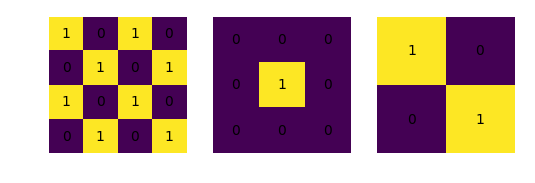

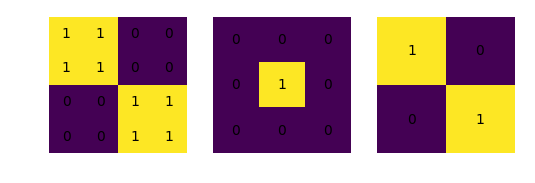

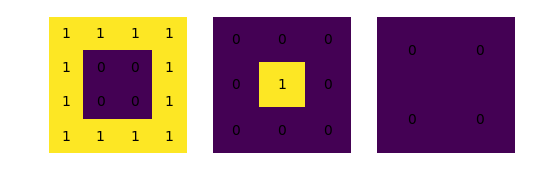

In [4]:
show_conv2d(image4_dots, image3_cent, (1, 1), 'VALID')
show_conv2d(image4_squa, image3_cent, (1, 1), 'VALID')
show_conv2d(image4_ring, image3_cent, (1, 1), 'VALID')

We now try with a different kernel: a vertical line. With VALID, it will consider only the pixels in the 4x4 image, without padding it. The output pixel will copy the values of the top, center and bottom pixels. 

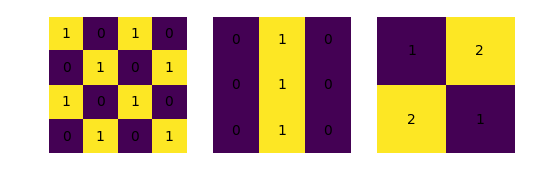

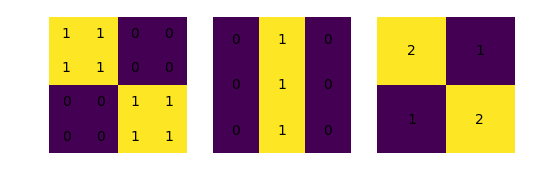

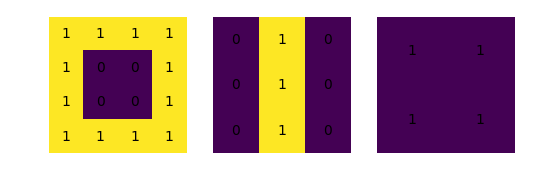

In [5]:
show_conv2d(image4_dots, image3_vert, (1, 1), 'VALID')
show_conv2d(image4_squa, image3_vert, (1, 1), 'VALID')
show_conv2d(image4_ring, image3_vert, (1, 1), 'VALID')

Half (same) padding, no strides ![half padding, no strides](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides.gif)

In this case, we do the same thing as we did earlier, but using the SAME padding: the kernel is now allowed to go outside the input image, and values outside it are padded with zeroes, but the center pixel of the kernel will always match a pixel of the input image. The output image will get larger, because now we can apply the kernel to every pixel of it, instead of the central ones.

According to TF arithmetics, we have an output image of 4, and a padding of 1: the 3x3 kernel will get one pixel outside the input image on both sides (1 extra pixel top, left, bottom and right).

In [6]:
compute_out_and_padding(4, 3, 1, 'SAME')

(4, 1.0)

As far as I know, there are no arbitrary or full paddings in tensorflow.

Note how, using `image3_cent`, we just copy the input to the output, because paddings and neighbors are ignored.

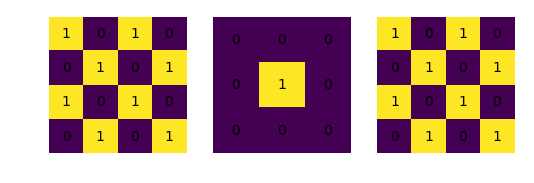

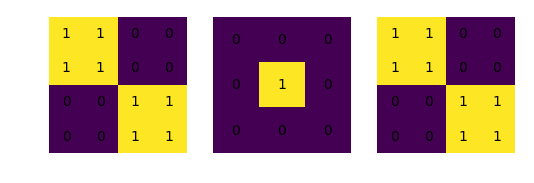

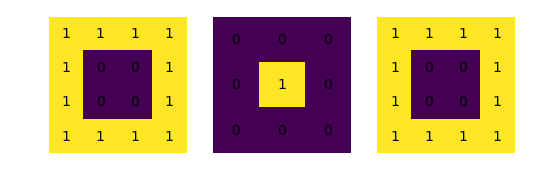

In [7]:
show_conv2d(image4_dots, image3_cent, (1, 1), 'SAME')
show_conv2d(image4_squa, image3_cent, (1, 1), 'SAME')
show_conv2d(image4_ring, image3_cent, (1, 1), 'SAME')

If we use `image3_vert` instead, we will go outside the figure and have a padded input.

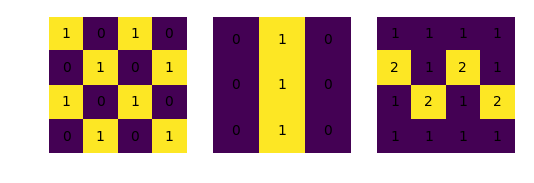

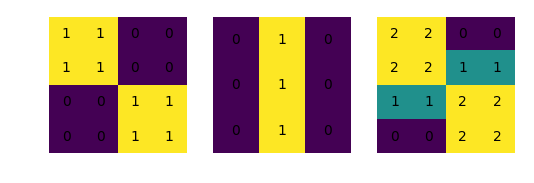

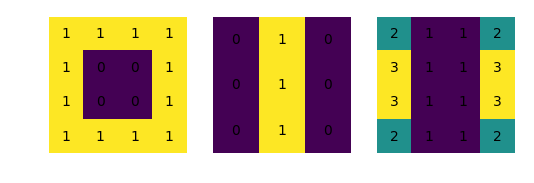

In [8]:
show_conv2d(image4_dots, image3_vert, (1, 1), 'SAME')
show_conv2d(image4_squa, image3_vert, (1, 1), 'SAME')
show_conv2d(image4_ring, image3_vert, (1, 1), 'SAME')

Let's see now what happens using strides with the VALID padding.

![no padding, with strides](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides.gif)

In [9]:
print(compute_out_and_padding(4, 2, 1, 'VALID'))
print(compute_out_and_padding(4, 2, 2, 'VALID'))
print(compute_out_and_padding(4, 2, 3, 'VALID'))

(3, 0)
(2, 0)
(1, 0)


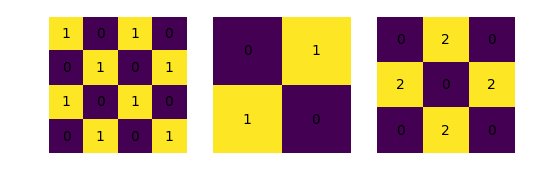

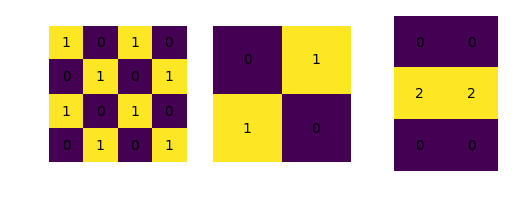

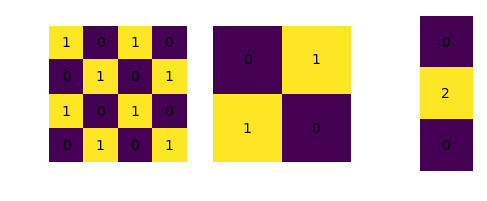

In [10]:
show_conv2d(image4_dots, image2_diag, strides=(1, 1), padding='VALID')
show_conv2d(image4_dots, image2_diag, (1, 2), 'VALID')
show_conv2d(image4_dots, image2_diag, (1, 3), 'VALID') 

With SAME padding and strides

(4, 0.5)
(2, 0.0)
(2, 0.5)


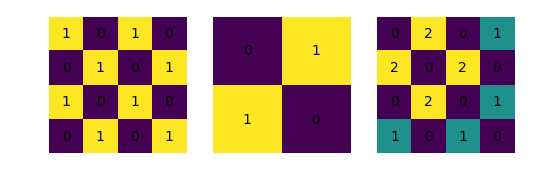

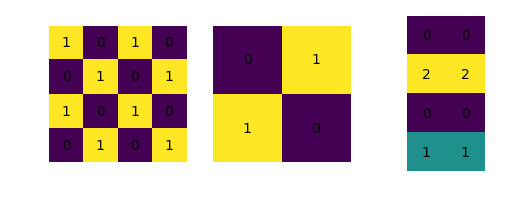

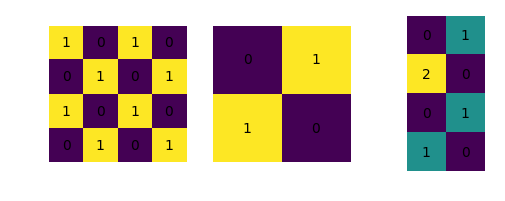

In [11]:
print(compute_out_and_padding(4, 2, 1, 'SAME'))
print(compute_out_and_padding(4, 2, 2, 'SAME'))
print(compute_out_and_padding(4, 2, 3, 'SAME'))
show_conv2d(image4_dots, image2_diag, strides=(1, 1), padding='SAME')
show_conv2d(image4_dots, image2_diag, (1, 2), 'SAME')
show_conv2d(image4_dots, image2_diag, (1, 3), 'SAME')

In the **first case**, note how the kernel starts from the top-left corner and moves right 4 times before stopping: the last time, half of the kernel is outside the image and the value 0 is used where there are no pixels. Note that the computed value for the padding is 0.5, meaning that there is no padding on the left (top), but there will be padding of 1 at the right (bottom).

In the **second case**, the kernel starts as before on the top-left corner and it moves just once, without overflow on the right side of the image. Two values are computed and there is no need for padding (computed padding is, in fact, 0).

In the **third case**, the computed padding is again 0.5 and, in fact, the kernel overflows the input of 1 pixel on the right.

In general, having a `int(n) + 0.5` computed padding means that the overflow will be of `n` pixels on left (top) side, but there will be a `n+1` overflow of the kernel on the right (bottom) side.

With a kernel of size 3, it may happen that the computed padding value is of 1.0, meaning that the kernel will overflow 1 pixel on the left (top) and right (bottom) sides, as shown below in the first and third examples, where the kernel is centered in the top-left corner (and, therefore, it overflows of 1 pixels on the left and top sides, which are padded with 0).

(4, 1.0)
(2, 0.5)
(2, 1.0)


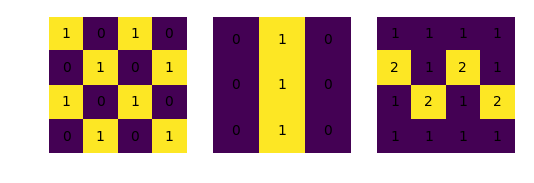

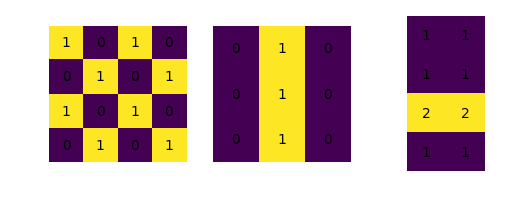

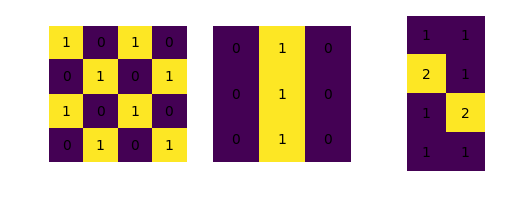

In [12]:
print(compute_out_and_padding(4, 3, 1, 'SAME'))
print(compute_out_and_padding(4, 3, 2, 'SAME'))
print(compute_out_and_padding(4, 3, 3, 'SAME'))
show_conv2d(image4_dots, image3_vert, strides=(1, 1), padding='SAME')
show_conv2d(image4_dots, image3_vert, (1, 2), 'SAME')
show_conv2d(image4_dots, image3_vert, (1, 3), 'SAME')

With a kernel size of 4, we may in fact obtain a computed padding of 1.5, meaning that 1 pixel will overflow on the left (top), but 2 pixels will overflow on the right (bottom).

(4, 1.5)
(2, 1.0)
(2, 1.5)


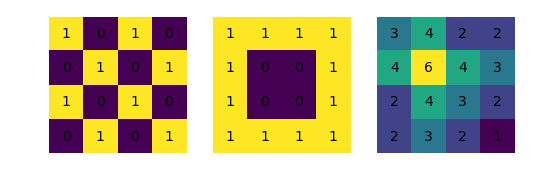

In [13]:
print(compute_out_and_padding(4, 4, 1, 'SAME'))
print(compute_out_and_padding(4, 4, 2, 'SAME'))
print(compute_out_and_padding(4, 4, 3, 'SAME'))
show_conv2d(image4_dots, image4_ring, strides=(1, 1), padding='SAME')

# Transposed convolution ("deconvolution")

A transposed convolution (a.k.a fractionally strided convolution, backward convolution or deconvolution) swaps the sized of the input and the output of a regular convolution: if you convolve an input of size 4x4 with a kernel 3x3 and method VALID, you get a 2x2 output. The transpose of this convolution takes a 2x2 input and applies a 3x3 kernel to produce a 4x4 output.

Let's start by seeing how it is done in TF. The `tf.nn.conv2d_transpose` operation is used.

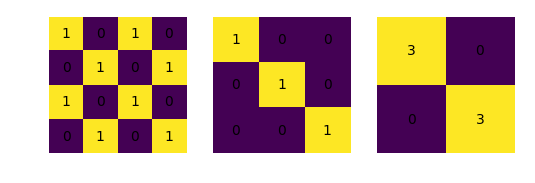

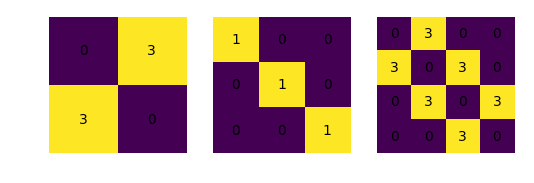

In [14]:
# Regular convolution: 4x4 input, 3x3 kernel, 2x2 output
show_conv2d(image4_dots, image3_diag, strides=(1, 1), padding='VALID')

# Transposed convolution: 2x2 input, 3x3 kernel, 4x4 output
with tf.Session() as sess:
    in_img = image2_diag * 3.0
    op = conv2d_t(in_img, image3_diag, (4, 4), (1, 1), 'VALID')
    show_pixel_image(in_img, image3_diag, op.eval().reshape(4, 4), show_text=True)

Note how, in the transposed convolution, the kernel fits in the output: with a 2x2 input, there are 2x2 positions of the kernel in the output image. If you multiply the kernel for the input value corresponding to the input position and you sum all the products, you get the final image. To make it more explicit, let's apply it using some negative weights in the kernel:

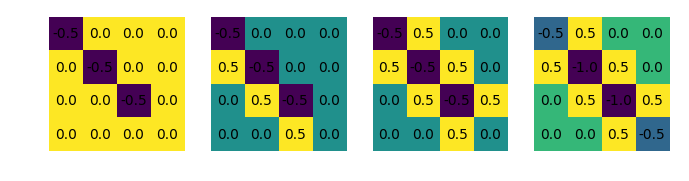

In [15]:
if True: # try setting this to False to see the same output as the conv2d_transpose above
    kernel = image2_diag - 0.5 # form -0.5 to 0.5
else:
    kernel = image2_diag

out_img = np.zeros((4, 4))
out_img[0:3,0:3] += image3_diag * kernel[0, 0] ; pos1 = out_img.copy()
out_img[1:4,0:3] += image3_diag * kernel[1, 0] ; pos2 = out_img.copy()
out_img[0:3,1:4] += image3_diag * kernel[0, 1] ; pos3 = out_img.copy()
out_img[1:4,1:4] += image3_diag * kernel[1, 1]
show_pixel_image(pos1, pos2, pos3, out_img, show_text=True, int_values=False)

It is possible to visualize better how the transposed convolution works by explicitly setting the padding of the input image, in fact it is always possible to transform any transposed convolution into a regular convolution.

In our case, to produce a 4x4 output image, it is necessary to pad the 2x2 input image with 2 empty pixels on the left, right, top and bottom.

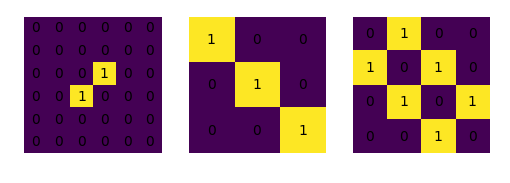

In [16]:
show_conv2d_any_pad(image2_diag, image3_diag, (1, 1), [(2, 2), (2, 2)], show_text=True)

Some more examples of transposed convolution with the equivalent convolution.

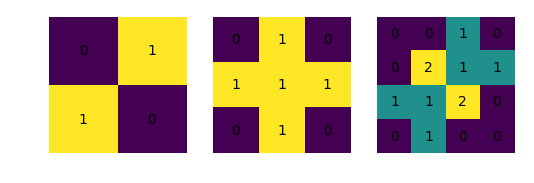

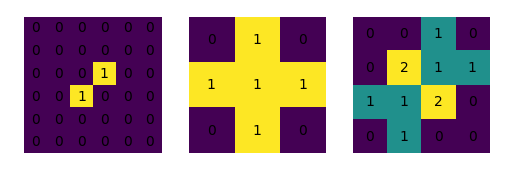

In [17]:
with tf.Session() as sess:
    op = conv2d_t(image2_diag, image3_cros, (4, 4), (1, 1), 'VALID')
    show_pixel_image(image2_diag, image3_cros, op.eval().reshape(4, 4), show_text=True)
# Or equivalently
show_conv2d_any_pad(image2_diag, image3_cros, (1, 1), [(2, 2), (2, 2)], show_text=True)

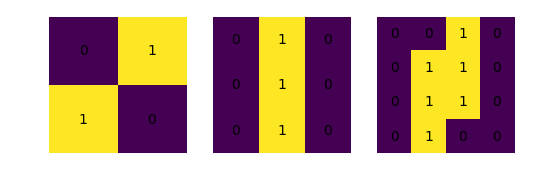

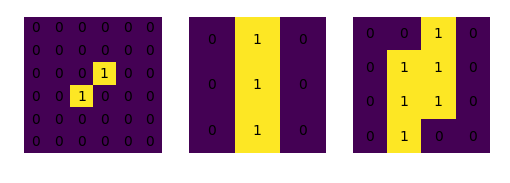

In [18]:
with tf.Session() as sess:
    op = conv2d_t(image2_diag, image3_vert, (4, 4), (1, 1), 'VALID')
    show_pixel_image(image2_diag, image3_vert, op.eval().reshape(4, 4), show_text=True)
# Or equivalently
show_conv2d_any_pad(image2_diag, image3_vert, (1, 1), [(2, 2), (2, 2)], show_text=True)

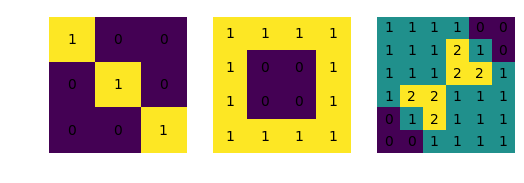

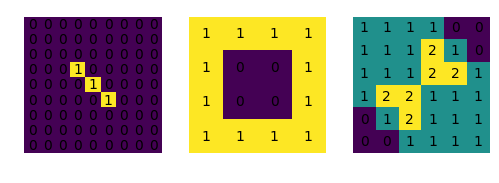

In [19]:
with tf.Session() as sess:
    op = conv2d_t(image3_diag, image4_ring, (6, 6), (1, 1), 'VALID')
    show_pixel_image(image3_diag, image4_ring, op.eval().reshape(6, 6), show_text=True)
# Or equivalently
show_conv2d_any_pad(image3_diag, image4_ring, (1, 1), [(3, 3), (3, 3)], show_text=True)

Consider now when the stride is greater than one.

![no padding, strides, transposed](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides_transposed.gif)

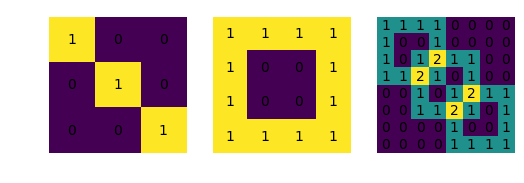

In [20]:
with tf.Session() as sess:
    op = conv2d_t(image3_diag, image4_ring, (8, 8), (2, 2), 'VALID')
    show_pixel_image(image3_diag, image4_ring, op.eval().reshape(8, 8), show_text=True)

To create an equivalent form, we have to change the input and pad some zeroes *within* the input

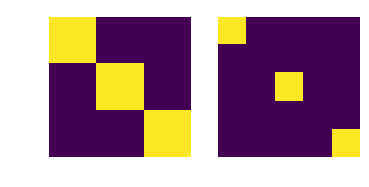

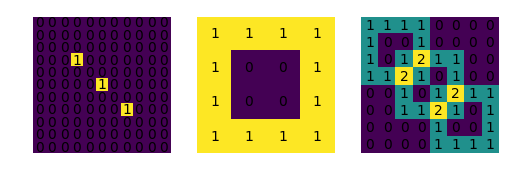

In [21]:
spaced_in = np.zeros((5, 5))
spaced_in[::2,::2] = image3_diag
show_pixel_image(image3_diag, spaced_in) # This is how the input is transformed
show_conv2d_any_pad(spaced_in, image4_ring, (1, 1), [(3, 3), (3, 3)], show_text=True)